Reading data from: c:\Users\alera\Desktop\ENTPE\MoCoM\MOCOM_project_2\Original network
Salvato: Analysis_Bidirectional_Edges_v2.png
Salvato: Analysis_Bidirectional_KPIs_v2.png


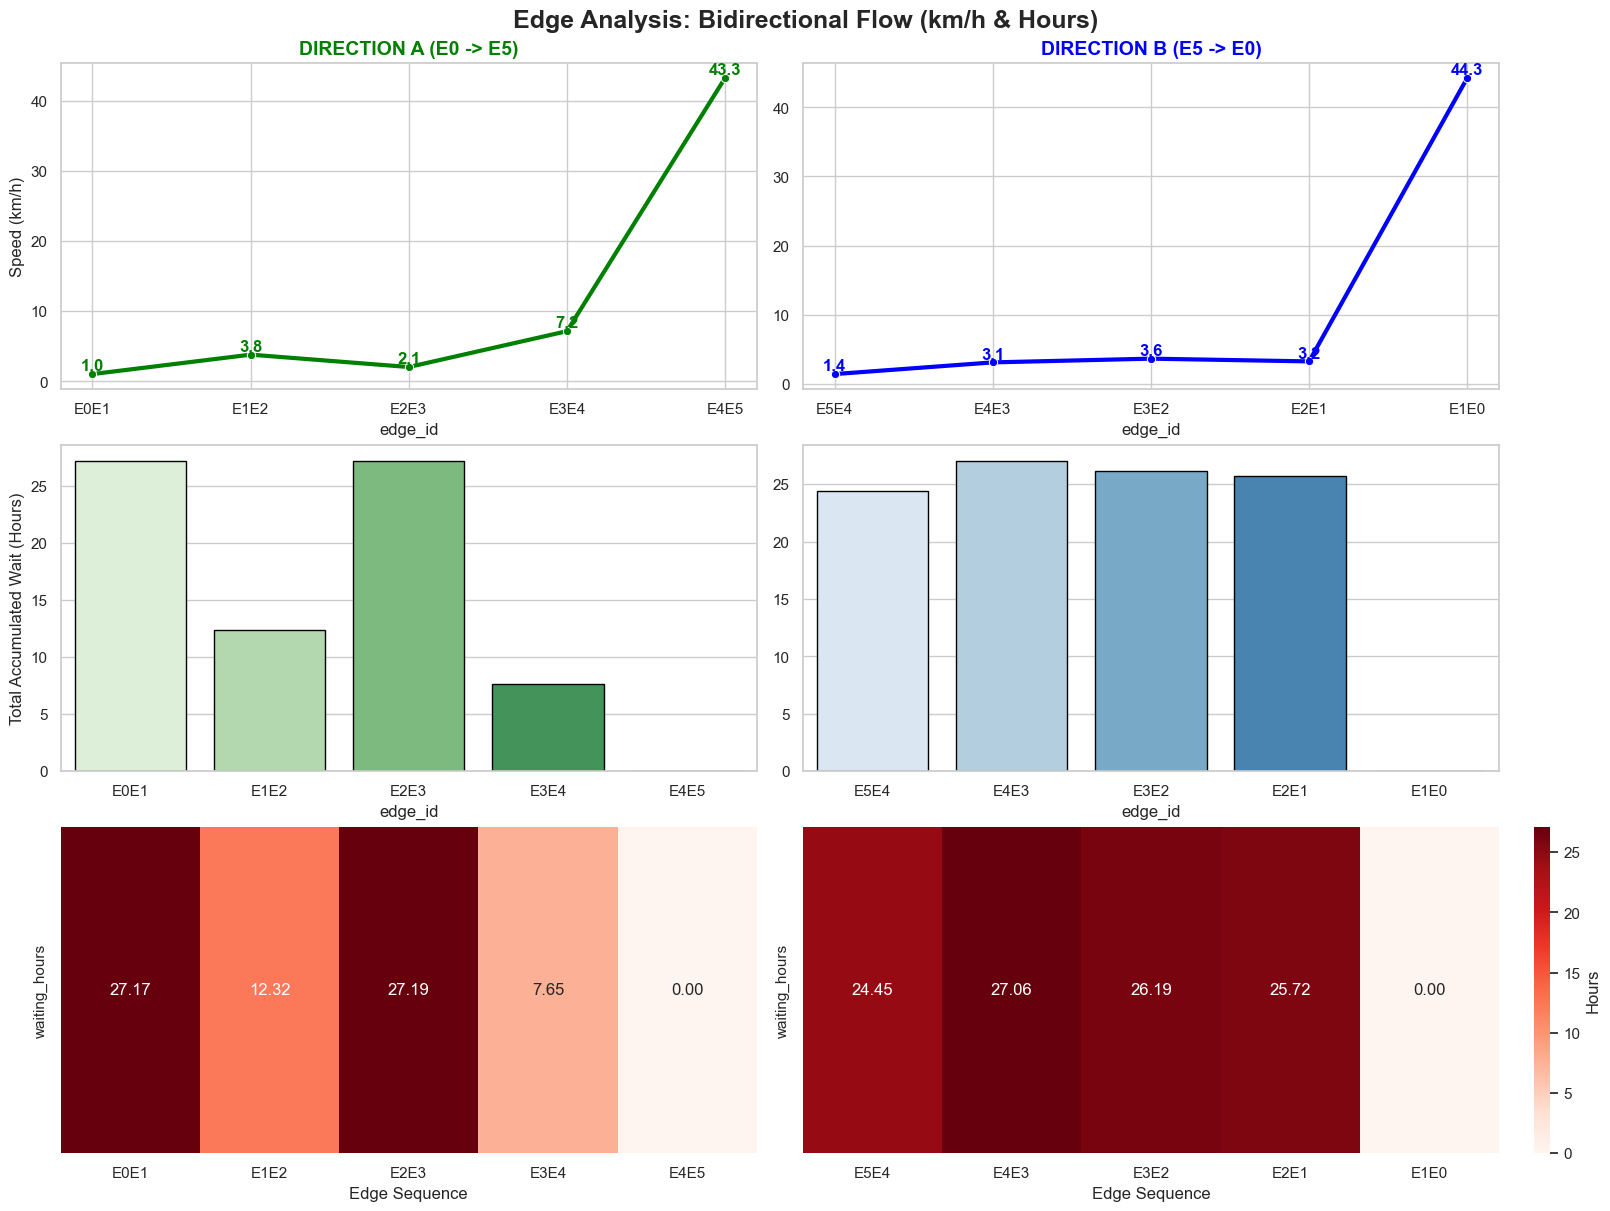

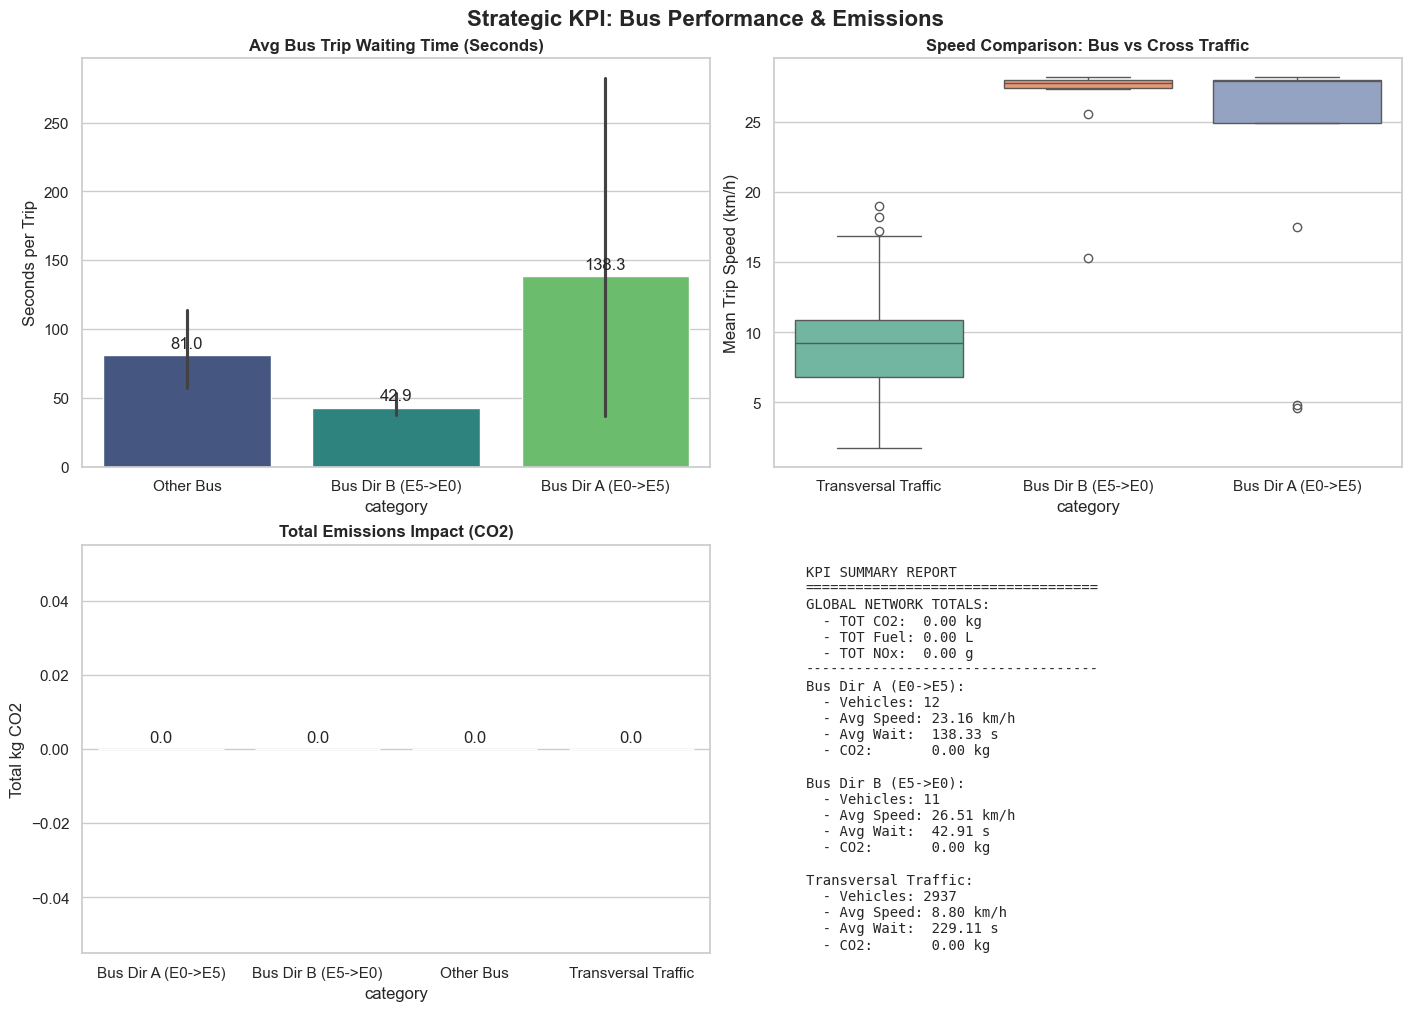

In [1]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ==========================================
# 1. CONFIGURAZIONE
# ==========================================
RESULTS_FOLDER = "Original network"

# DEFINIZIONE DELLE DUE DIREZIONI
DIR_A_EDGES = ["E0E1", "E1E2", "E2E3", "E3E4", "E4E5"] # Andata (Nord->Sud)
DIR_B_EDGES = ["E5E4", "E4E3", "E3E2", "E2E1", "E1E0"] # Ritorno (Sud->Nord)

# CLASSIFICAZIONE VEICOLI
def classify_vehicle(veh_id):
    prefix = veh_id.split('.')[0] if '.' in veh_id else veh_id
    
    # --- DIREZIONE A (E0 -> E5) ---
    if prefix in ['f_7']: 
        return "Bus Dir A (E0->E5)", "Bus", "Dir A"
    
    # --- DIREZIONE B (E5 -> E0) ---
    elif prefix in ['f_6']: 
        return "Bus Dir B (E5->E0)", "Bus", "Dir B"
        
    # --- ALTRI ---
    elif prefix in ['f_4', 'f_5']:
        return "Other Bus", "Bus", "Other"
    elif prefix in ['f_0', 'f_1', 'f_2', 'f_3']:
        return "Transversal Traffic", "Traffic", "Transversal"
    else:
        return "Background", "Car", "Other"

# ==========================================
# 2. CARICAMENTO DATI
# ==========================================
def load_data(folder):
    trip_path = os.path.join(folder, "tripinfo.xml")
    edge_path = os.path.join(folder, "bus_results.xml")

    # --- 1. TRIPINFO (Veicoli singoli) ---
    trips = []
    if os.path.exists(trip_path):
        tree = ET.parse(trip_path)
        for t in tree.getroot().findall('tripinfo'):
            cat, vtype, route_group = classify_vehicle(t.get('id'))
            
            # --- ESTRAZIONE EMISSIONI E CONSUMI ---
            # SUMO usa solitamente _abs per i totali (mg o ml)
            
            # 1. CO2 (mg -> kg)
            co2_mg = float(t.get('CO2_abs', 0))
            if co2_mg == 0: co2_mg = float(t.get('CO2', 0)) # Fallback
            co2_kg = co2_mg / 1_000_000
            
            # 2. Fuel (ml -> L)
            fuel_ml = float(t.get('fuel_abs', 0))
            if fuel_ml == 0: fuel_ml = float(t.get('fuel', 0))
            fuel_l = fuel_ml / 1000.0
            
            # 3. NOx (mg -> g)
            nox_mg = float(t.get('NOx_abs', 0))
            if nox_mg == 0: nox_mg = float(t.get('NOx', 0))
            nox_g = nox_mg / 1000.0

            duration = float(t.get('duration'))
            route_len = float(t.get('routeLength', 0))
            
            # Calcolo velocità media viaggio in km/h
            speed_kmh = (route_len / duration) * 3.6 if duration > 0 else 0

            trips.append({
                'id': t.get('id'),
                'category': cat,
                'type': vtype,
                'route_group': route_group,
                'waitingTime': float(t.get('waitingTime')),
                'duration': duration,
                'routeLength': route_len,
                'speed_kmh': speed_kmh,
                'co2_kg': co2_kg,
                'fuel_l': fuel_l,
                'nox_g': nox_g
            })
    df_trips = pd.DataFrame(trips)

    # --- 2. EDGE DATA (Strade) ---
    edges_stats = []
    if os.path.exists(edge_path):
        tree = ET.parse(edge_path)
        intervals = tree.getroot().findall('interval')
        if intervals:
            # Usiamo l'ultimo intervallo
            for e in intervals[-1].findall('edge'):
                eid = e.get('id')
                direction = "None"
                order = 99
                
                if eid in DIR_A_EDGES:
                    direction = "Dir A (E0->E5)"
                    order = DIR_A_EDGES.index(eid)
                elif eid in DIR_B_EDGES:
                    direction = "Dir B (E5->E0)"
                    order = DIR_B_EDGES.index(eid)
                
                if direction != "None":
                    speed_ms = float(e.get('speed', 0))
                    wait_sec = float(e.get('waitingTime', 0)) 
                    
                    edges_stats.append({
                        'edge_id': eid,
                        'direction': direction,
                        'order': order,
                        'speed_kmh': speed_ms * 3.6,        # m/s -> km/h
                        'waiting_hours': wait_sec / 3600.0, # seconds -> hours
                        'density': float(e.get('density', 0))
                    })
    
    df_edges = pd.DataFrame(edges_stats)
    if not df_edges.empty:
        df_edges = df_edges.sort_values(by=['direction', 'order'])

    return df_trips, df_edges

# ==========================================
# 3. VISUALIZZAZIONE BIDIREZIONALE
# ==========================================
def create_dashboard(df_trips, df_edges):
    sns.set_theme(style="whitegrid")
    
    # Separazione dataset Archi
    df_edges_A = df_edges[df_edges['direction'] == "Dir A (E0->E5)"]
    df_edges_B = df_edges[df_edges['direction'] == "Dir B (E5->E0)"]

    # --- FIGURA 1: ANALISI ARCHI (SPEED & WAIT) ---
    fig1, axes = plt.subplots(3, 2, figsize=(16, 12), constrained_layout=True)
    fig1.suptitle("Edge Analysis: Bidirectional Flow (km/h & Hours)", fontsize=18, fontweight='bold')

    # Titoli colonne
    axes[0,0].set_title("DIRECTION A (E0 -> E5)", fontsize=14, color='green', fontweight='bold')
    axes[0,1].set_title("DIRECTION B (E5 -> E0)", fontsize=14, color='blue', fontweight='bold')

    # ROW 1: SPEED (km/h)
    if not df_edges_A.empty:
        sns.lineplot(data=df_edges_A, x='edge_id', y='speed_kmh', marker='o', color='green', ax=axes[0,0], linewidth=3)
        axes[0,0].set_ylabel("Speed (km/h)")
        for x, y in zip(range(len(df_edges_A)), df_edges_A['speed_kmh']):
            axes[0,0].text(x, y+0.5, f"{y:.1f}", ha='center', color='green', fontweight='bold')
            
    if not df_edges_B.empty:
        sns.lineplot(data=df_edges_B, x='edge_id', y='speed_kmh', marker='o', color='blue', ax=axes[0,1], linewidth=3)
        axes[0,1].set_ylabel("")
        for x, y in zip(range(len(df_edges_B)), df_edges_B['speed_kmh']):
            axes[0,1].text(x, y+0.5, f"{y:.1f}", ha='center', color='blue', fontweight='bold')

    # ROW 2: TOTAL ACCUMULATED WAITING TIME (Hours)
    if not df_edges_A.empty:
        sns.barplot(data=df_edges_A, x='edge_id', y='waiting_hours', hue='edge_id', palette="Greens", ax=axes[1,0], legend=False, edgecolor='black')
        axes[1,0].set_ylabel("Total Accumulated Wait (Hours)")
        
    if not df_edges_B.empty:
        sns.barplot(data=df_edges_B, x='edge_id', y='waiting_hours', hue='edge_id', palette="Blues", ax=axes[1,1], legend=False, edgecolor='black')
        axes[1,1].set_ylabel("")

    # ROW 3: HEATMAPS (Hours)
    if not df_edges_A.empty:
        matrix_A = df_edges_A[['edge_id', 'waiting_hours']].set_index('edge_id').T
        sns.heatmap(matrix_A, annot=True, fmt=".2f", cmap="Reds", ax=axes[2,0], cbar=False)
        axes[2,0].set_xlabel("Edge Sequence")
        
    if not df_edges_B.empty:
        matrix_B = df_edges_B[['edge_id', 'waiting_hours']].set_index('edge_id').T
        sns.heatmap(matrix_B, annot=True, fmt=".2f", cmap="Reds", ax=axes[2,1], cbar_kws={'label': 'Hours'})
        axes[2,1].set_xlabel("Edge Sequence")

    plt.savefig("Analysis_Bidirectional_Edges_v2.png", dpi=300)
    print("Salvato: Analysis_Bidirectional_Edges_v2.png")

    # --- FIGURA 2: CONFRONTO BUS vs RETE + EMISSIONS ---
    fig2, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)
    fig2.suptitle("Strategic KPI: Bus Performance & Emissions", fontsize=16, fontweight='bold')

    # 1. Waiting Time Comparison
    target_buses = df_trips[df_trips['type'] == 'Bus']
    if not target_buses.empty:
        sns.barplot(data=target_buses, x='category', y='waitingTime', hue='category', palette="viridis", ax=axes[0,0], legend=False)
        axes[0,0].set_title("Avg Bus Trip Waiting Time (Seconds)", fontweight='bold')
        axes[0,0].set_ylabel("Seconds per Trip")
        for c in axes[0,0].containers:
            axes[0,0].bar_label(c, fmt='%.1f', padding=3)

    # 2. Speed Comparison
    comp_groups = ["Bus Dir A (E0->E5)", "Bus Dir B (E5->E0)", "Transversal Traffic"]
    speed_df = df_trips[df_trips['category'].isin(comp_groups)]
    
    if not speed_df.empty:
        sns.boxplot(data=speed_df, x='category', y='speed_kmh', hue='category', palette="Set2", ax=axes[0,1], legend=False)
        axes[0,1].set_title("Speed Comparison: Bus vs Cross Traffic", fontweight='bold')
        axes[0,1].set_ylabel("Mean Trip Speed (km/h)")

    # 3. Emissions Breakdown (CO2 kg) - Bottom Left
    em_df = df_trips.groupby('category')['co2_kg'].sum().reset_index()
    # Filtriamo per rendere leggibile
    em_df = em_df[em_df['category'].isin(comp_groups + ["Other Bus"])]
    
    if not em_df.empty:
        sns.barplot(data=em_df, x='category', y='co2_kg', hue='category', palette="Greys_r", ax=axes[1,0], legend=False)
        axes[1,0].set_title("Total Emissions Impact (CO2)", fontweight='bold')
        axes[1,0].set_ylabel("Total kg CO2")
        for c in axes[1,0].containers:
            axes[1,0].bar_label(c, fmt='%.1f', padding=3)

    # 4. Text Summary Box (With GLOBAL TOTALS) - Bottom Right
    axes[1,1].axis('off')
    
    # Calcolo totali globali
    total_co2 = df_trips['co2_kg'].sum()
    total_fuel = df_trips['fuel_l'].sum()
    total_nox = df_trips['nox_g'].sum()
    
    text_str = "KPI SUMMARY REPORT\n" + "="*35 + "\n"
    
    # Sezione Totali Globali
    text_str += "GLOBAL NETWORK TOTALS:\n"
    text_str += f"  - TOT CO2:  {total_co2:,.2f} kg\n"
    text_str += f"  - TOT Fuel: {total_fuel:,.2f} L\n"
    text_str += f"  - TOT NOx:  {total_nox:,.2f} g\n"
    text_str += "-"*35 + "\n"

    # Sezione per Categoria
    for cat in comp_groups:
        subset = df_trips[df_trips['category'] == cat]
        if not subset.empty:
            avg_wait = subset['waitingTime'].mean()
            avg_speed = subset['speed_kmh'].mean()
            cat_co2 = subset['co2_kg'].sum()
            count = len(subset)
            text_str += f"{cat}:\n"
            text_str += f"  - Vehicles: {count}\n"
            text_str += f"  - Avg Speed: {avg_speed:.2f} km/h\n"
            text_str += f"  - Avg Wait:  {avg_wait:.2f} s\n"
            text_str += f"  - CO2:       {cat_co2:.2f} kg\n\n"
    
    axes[1,1].text(0.05, 0.95, text_str, fontsize=10, fontfamily='monospace', verticalalignment='top', 
                   bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))

    plt.savefig("Analysis_Bidirectional_KPIs_v2.png", dpi=300)
    print("Salvato: Analysis_Bidirectional_KPIs_v2.png")
    plt.show()

# ==========================================
# 4. ESECUZIONE
# ==========================================
if __name__ == "__main__":
    base_dir = os.getcwd()
    target_dir = os.path.join(base_dir, RESULTS_FOLDER)
    
    if not os.path.exists(target_dir):
        # Fallback path
        target_dir = os.path.join(base_dir, "MOCOM_project_2", RESULTS_FOLDER)

    print(f"Reading data from: {target_dir}")
    try:
        trips, edges = load_data(target_dir)
        create_dashboard(trips, edges)
    except Exception as e:
        print(f"ERRORE: {e}")
        import traceback
        traceback.print_exc()